**Import necessary libraries**

In [1]:
# Torch
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.models import vit_b_16, VisionTransformer
from torchvision.models.feature_extraction import create_feature_extractor

In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Data Loading and Preprocessing**

In [3]:
# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])

In [4]:
# Load the dataset from the root directory
dataset = datasets.ImageFolder(root='dataset', transform=data_transform)

# Splitting the dataset
train_size = int(0.7 * len(dataset)) 
val_size = int(0.15 * len(dataset)) 
test_size = len(dataset) - train_size - val_size 

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

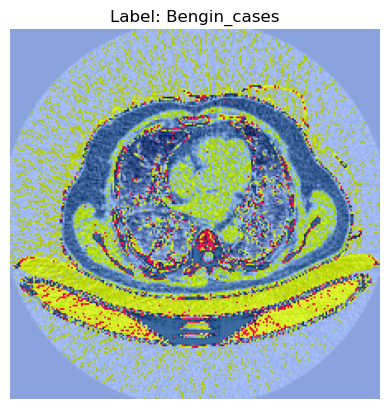

In [5]:
# Access an image and its label
img_tensor, label = dataset[0]  

# To visualize the image, convert the tensor back to a PIL image
img = transforms.ToPILImage()(img_tensor)

# Display the image using PIL
img.show()

plt.imshow(img)
# Display the label of the image
plt.title(f'Label: {dataset.classes[label]}')  
plt.axis('off') 
plt.show()

**Define the Model**

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)  
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)  
        
        self.fc = nn.Linear(in_features=64 * 56 * 56, out_features=3)  
        self.dropout3 = nn.Dropout(0.5)  

    def forward(self, x):
        x = self.pool(self.bn1(self.act1(self.conv1(x))))
        x = self.dropout1(x)
        x = self.pool(self.bn2(self.act2(self.conv2(x))))
        x = self.dropout2(x)
        x = torch.flatten(x, 1)  
        x = self.dropout3(x)
        x = self.fc(x)
        return x


**Initialize Model, Loss Function, and Optimizer**

In [7]:
model = SimpleCNN()
model.to(device)  

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=200704, out_features=3, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
)

**Train and evaluate the model**

In [8]:
# Initialize lists to store accuracies and losses
train_accuracies = []
test_accuracies = []
validation_accuracies = []

train_losses = []
validation_losses = []

In [9]:
def train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10):
    # Define your device at the beginning of your function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move your model to the selected device
    model.to(device)
    
    # Initialize or reinitialize your optimizer here, after moving the model to the device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        correct_validation = 0
        total_validation = 0
        validation_loss = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(validation_loss / len(validation_loader))

        # Evaluate on the test set
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Loss: {validation_loss/len(validation_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Accuracy: {validation_accuracy:.2f}%, "
              f"Test Accuracy: {test_accuracy:.2f}%")

In [11]:
train_and_evaluate(model, train_loader, validation_loader, test_loader, epochs=10)

Epoch 1, Train Loss: 2.2223, Validation Loss: 0.6918, Train Accuracy: 66.88%, Validation Accuracy: 71.95%, Test Accuracy: 63.86%
Epoch 2, Train Loss: 0.2345, Validation Loss: 0.2706, Train Accuracy: 92.31%, Validation Accuracy: 87.20%, Test Accuracy: 81.33%
Epoch 3, Train Loss: 0.0563, Validation Loss: 0.1321, Train Accuracy: 98.17%, Validation Accuracy: 96.34%, Test Accuracy: 90.36%
Epoch 4, Train Loss: 0.0494, Validation Loss: 0.0771, Train Accuracy: 98.04%, Validation Accuracy: 97.56%, Test Accuracy: 94.58%
Epoch 5, Train Loss: 0.0307, Validation Loss: 0.1699, Train Accuracy: 99.35%, Validation Accuracy: 93.90%, Test Accuracy: 87.35%
Epoch 6, Train Loss: 0.0279, Validation Loss: 0.1227, Train Accuracy: 98.70%, Validation Accuracy: 96.34%, Test Accuracy: 93.37%
Epoch 7, Train Loss: 0.0473, Validation Loss: 0.1538, Train Accuracy: 98.83%, Validation Accuracy: 91.46%, Test Accuracy: 91.57%
Epoch 8, Train Loss: 0.0160, Validation Loss: 0.0838, Train Accuracy: 99.61%, Validation Accuracy

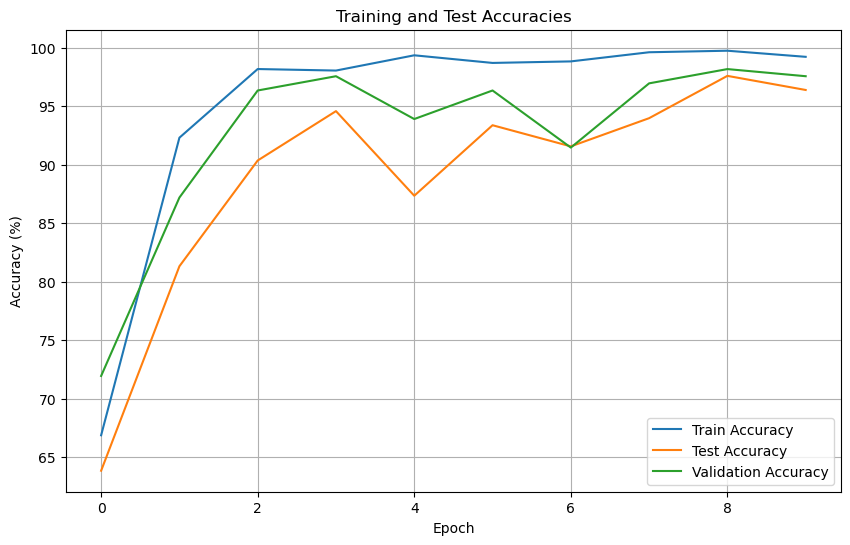

In [12]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()

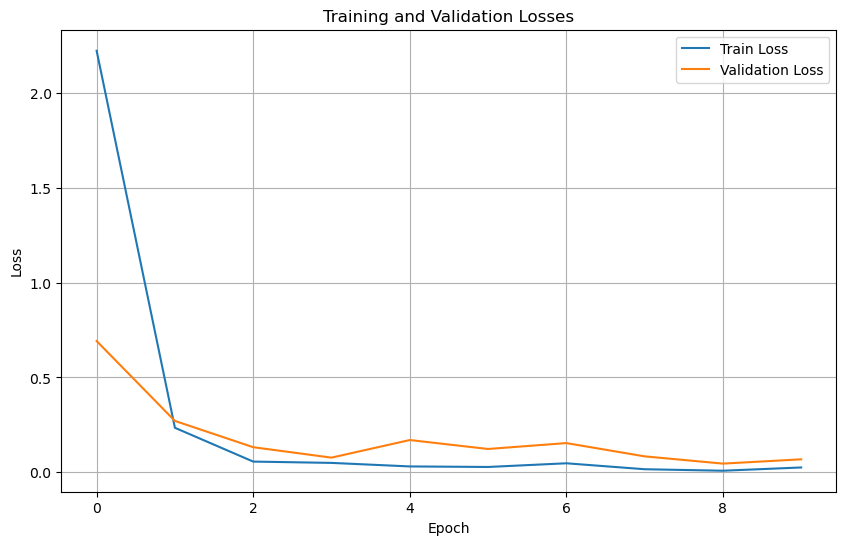

In [13]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

**Second model trial**

In [23]:
class CNNViT(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNViT, self).__init__()
        
        # Define the CNN part
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            # Do not flatten here; we'll reshape before feeding into ViT
        )
        
        # Load a pre-trained Vision Transformer without specifying num_classes
        self.vit = vit_b_16(pretrained=True)
        
        # Replace the classifier head for the correct number of classes
        in_features = self.vit.heads[0].in_features  # Get the number of input features for the classifier
        self.vit.heads[0] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.cnn(x)
        
        # Adjust features to match the expected input dimensions for ViT
        # This requires knowing the expected patch size and embedding dimension of the ViT
        # Assuming the CNN output size is compatible with the ViT input
        B, C, H, W = x.shape
        x = x.view(B, C*H*W)  # Flatten the features
        
        # We skip the part that directly uses 'embed_dim' and reshape based on actual ViT input requirements
        # For example, if ViT expects a sequence, we might need to adjust the sequence length and feature dimension
        
        # Pass through the Vision Transformer
        x = self.vit(x)
        
        return x


In [24]:
model2 = CNNViT(3)
model2.to(device)  

d:\Users\ZJY\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\ZJY\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNViT(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_feat

In [25]:
# Initialize lists to store accuracies and losses
train_accuracies = []
test_accuracies = []
validation_accuracies = []

train_losses = []
validation_losses = []

In [26]:
train_and_evaluate(model2, train_loader, validation_loader, test_loader, epochs=10)

ValueError: not enough values to unpack (expected 4, got 2)